In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np
from scipy.io import wavfile
from scipy import signal, stats
import peakutils, wfdb, pywt
import csv
import os, statistics
from datetime import datetime
import heartpy as hp
%matplotlib notebook
# import neurokit2 as nk

# Import E4 csv files

In [2]:
# read E4 data, clean up with corrected timstamp and store the csv files in dict
def read_E4(filepath, date):
    # HR data -- started 10 seconds later than other metrics
    hr = pd.read_csv(filepath+str('\HR.csv'), header = None)
    # clean up HR file
    start_time = hr.values[0]
    hr_samp_rate = hr.values[1]
    hr = hr.drop(labels = [0, 1], axis = 0, inplace = False)
    hr['Timestamp'] = list(range(0, len(hr),1))
    hr['Timestamp'] = hr['Timestamp'].apply(lambda x: x/hr_samp_rate+start_time)
    hr['Timestamp'] = hr['Timestamp'].str.get(0)
    hr['Second'] = hr['Timestamp']
    hr = hr.set_index('Timestamp')
    hr['Second'] = hr['Second'].apply(lambda x: x-hr.index[0])
    hr.columns = ['Heart rate', 'Second']
    
    
    # EDA data
    eda = pd.read_csv(filepath+str('\EDA.csv'), header = None)
    #start_time = eda.values[0]
    eda_samp_rate = eda.values[1]
    eda = eda.drop(labels = [0, 1], axis = 0, inplace = False)
    eda['Timestamp'] = list(range(0, len(eda),1))
    eda['Timestamp'] = eda['Timestamp'].apply(lambda x: x/eda_samp_rate+start_time)
    eda['Timestamp'] = eda['Timestamp'].str.get(0)
    eda['Second'] = eda['Timestamp']
    eda = eda.set_index('Timestamp')
    eda['Second'] = eda['Second'].apply(lambda x: x-eda.index[0])
    eda.columns = ['EDA', 'Second']

    temp = pd.read_csv(filepath+str('\TEMP.csv'), header = None)
    # clean up TEMP file
    #start_time = temp.values[0]
    temp_samp_rate = temp.values[1]
    temp = temp.drop(labels = [0, 1], axis = 0, inplace = False)
    temp['Timestamp'] = list(range(0, len(temp),1))
    temp['Timestamp'] = temp['Timestamp'].apply(lambda x: x/temp_samp_rate+start_time)
    temp['Timestamp'] = temp['Timestamp'].str.get(0)
    temp['Second'] = temp['Timestamp']
    temp = temp.set_index('Timestamp')
    temp['Second'] = temp['Second'].apply(lambda x: x-temp.index[0])
    temp.columns = ['Temp', 'Second']
    
    ibi = pd.read_csv(filepath+str('\IBI.csv'), header = None) # no correction of timestamp needed
    ibi = ibi.drop(labels = [0, 1], axis = 0, inplace = False)
    ibi.columns = ['Second', 'IBI']
    
    bvp = pd.read_csv(filepath+str('\BVP.csv'), header = None)
    #start_time = bvp.values[0]
    bvp_samp_rate = bvp.values[1]
    bvp = bvp.drop(labels = [0, 1], axis = 0, inplace = False)
    bvp['Timestamp'] = list(range(0, len(bvp),1))
    bvp['Timestamp'] = bvp['Timestamp'].apply(lambda x: np.round(x/bvp_samp_rate+start_time, 2))
    bvp['Timestamp'] = bvp['Timestamp'].str.get(0)
    bvp['Second'] = bvp['Timestamp']
    bvp = bvp.set_index('Timestamp')
    bvp['Second'] = bvp['Second'].apply(lambda x: x-bvp.index[0])
    bvp.columns = ['BVP', 'Second']
    
    data_dict = {'Date':date, 'HR':hr, 'EDA':eda, 'TEMP':temp, 'IBI':ibi, 'BVP':bvp}
    return data_dict 

In [3]:
# input data filepath and date
filepath_yh = r'C:\Users\maoyuan2\Documents\RADWear Stress Detection data analysis\Yang\A0381C_220211-135123'
filepath_mh = r'C:\Users\maoyuan2\Documents\RADWear Stress Detection data analysis\Max\A0340C_220211-190925'
date_yh = filepath_yh[-13:-7] #(year-month-day)
date_mh = filepath_mh[-13:-7]
data_yh = read_E4(filepath_yh,date_yh)
data_mh = read_E4(filepath_mh,date_mh)


In [4]:
tags = pd.read_csv(filepath_yh+str('\\tags.csv'), header = None)
tags = tags.values[:]

In [5]:
data_mh['BVP']

,BVP,Second
Timestamp,,
1.644607e+09,-0.00,0.00
1.644607e+09,-0.00,0.02
1.644607e+09,-0.00,0.03
1.644607e+09,-0.00,0.05
1.644607e+09,-0.00,0.06
...,...,...
1.644607e+09,69.71,428.75
1.644607e+09,68.59,428.77
1.644607e+09,65.54,428.78


## Plot raw data 

In [8]:
# Examine BVP dataframe and find tagged events timestamp
pd.options.display.float_format = '{:.2f}'.format
bvp_yh = data_yh['BVP']
bvp_yh = bvp_yh.reset_index()
# tagged events and corresponding BVP values and seconds
tags = tags.astype(np.float64)
bvp_yh.loc[bvp_yh['Timestamp'].isin(tags)]

,Timestamp,BVP,Second
142888,1644589725.62,69.27,2232.62
261506,1644591579.03,12.01,4086.03
616639,1644597127.98,102.63,9634.98
1168439,1644605749.86,1.77,18256.86
1432023,1644609868.36,98.86,22375.36
2032006,1644619243.09,-47.08,31750.09


In [38]:
#plot as subfigures
def plot_raw_e4(e4_data):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
    ax1.plot(e4_data['BVP']['Second'], e4_data['BVP']['BVP'])
    ax1.set_ylabel('BVP')
    ax1.set_title('Empatica E4 raw data')

    ax2.plot(e4_data['HR']['Second'], e4_data['HR']['Heart rate'])
    ax2.set_ylabel('HR (bpm)')

    ax3.plot(e4_data['TEMP']['Second'], e4_data['TEMP']['Temp'])
    ax3.set_ylabel("Body Temp ($^\circ$C)")

    ax4.plot(e4_data['EDA']['Second'], e4_data['EDA']['EDA'])
    ax4.set_ylabel('EDA (\u03BCS)')
    ax4.set_xlabel('Time (s)')

<IPython.core.display.Javascript object>


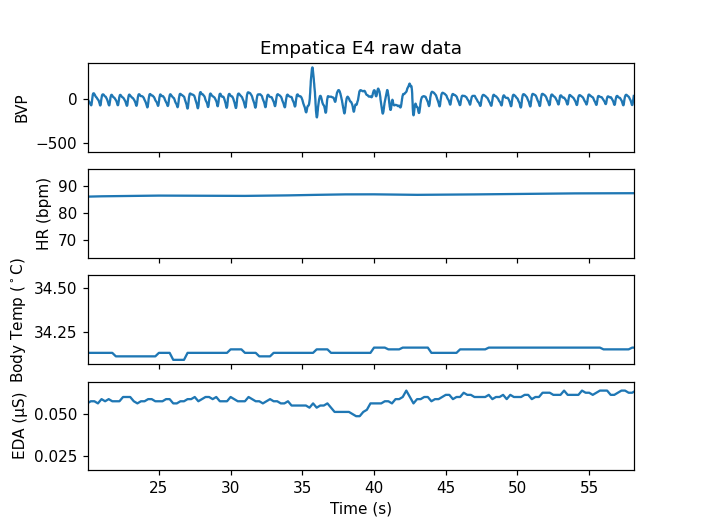

In [11]:
plot_raw_e4(data_mh)

# Extract PPG signal from DataFrame

In [12]:
# Examine BVP dataframe and find tagged events timestamp
pd.options.display.float_format = '{:.2f}'.format
bvp_yh = data_yh['BVP']
bvp_yh = bvp_yh.reset_index()
# tagged events and corresponding BVP values and seconds
tags = tags.astype(np.float64)
bvp_yh.loc[bvp_yh['Timestamp'].isin(tags)]

,Timestamp,BVP,Second
142888,1644589725.62,69.27,2232.62
261506,1644591579.03,12.01,4086.03
616639,1644597127.98,102.63,9634.98
1168439,1644605749.86,1.77,18256.86
1432023,1644609868.36,98.86,22375.36
2032006,1644619243.09,-47.08,31750.09


In [13]:
# my own E4 data
bvp_mh = data_mh['BVP']

# Preprocessing of PPG signal (skip)

In [11]:
#filter using savgol filter
bvp_yh_filtered = signal.savgol_filter(bvp_yh['BVP'], 49, 2)

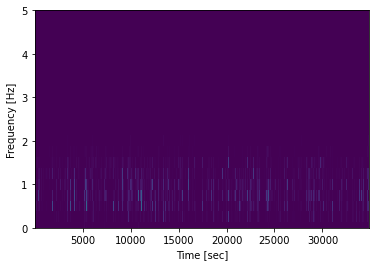

In [12]:
f, t, bvp_yh_spect_filt = signal.spectrogram(bvp_yh_filtered, fs = 64)
plt.pcolormesh(t, f, bvp_yh_spect_filt, shading = 'nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)  
plt.show()

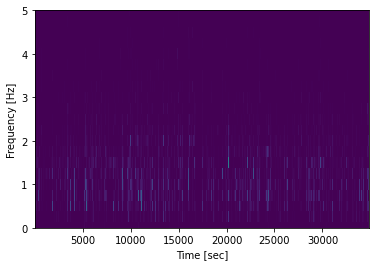

In [13]:
f, t, bvp_yh_spect = signal.spectrogram(bvp_yh['BVP'], fs = 64)
plt.pcolormesh(t, f, bvp_yh_spect, shading = 'nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)  
plt.show()

Text(0.5, 1.0, 'E4 BVP Spectrogram (filtered signal)')

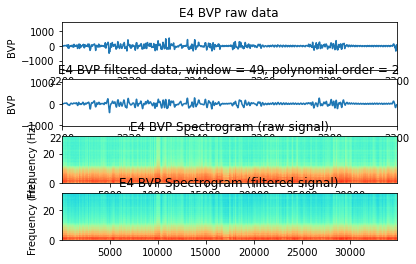

In [14]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False)
ax1.plot(bvp_yh['Second'], bvp_yh['BVP'])
ax1.set_ylabel('BVP')
ax1.set_xlim(2200, 2300)
ax1.set_title('E4 BVP raw data')

ax2.plot(bvp_yh['Second'], bvp_yh_filtered)
ax2.set_ylabel('BVP')
ax2.set_xlim(2200, 2300)
ax2.set_title('E4 BVP filtered data, window = 49, polynomial order = 2')

ax3.specgram(bvp_yh['BVP'], Fs = 64, cmap = 'rainbow')
ax3.set_ylabel('Frequency (Hz)')

ax3.set_title('E4 BVP Spectrogram (raw signal)')

ax4.specgram(bvp_yh_filtered, Fs = 64, cmap = 'rainbow')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('E4 BVP Spectrogram (filtered signal)')


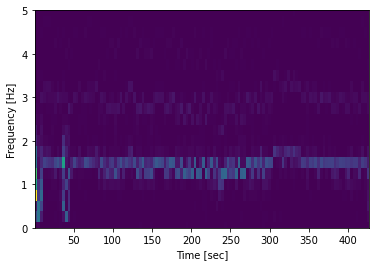

In [15]:
#bvp_mh = bvp_mh.reset_index()
f, t, bvp_spect_mh = signal.spectrogram(bvp_mh['BVP'], fs = 64)
plt.pcolormesh(t, f, bvp_spect_mh, shading = 'nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)  
plt.show()

In [16]:
bvp_mh_filtered = signal.savgol_filter(bvp_mh['BVP'], 15, 2)

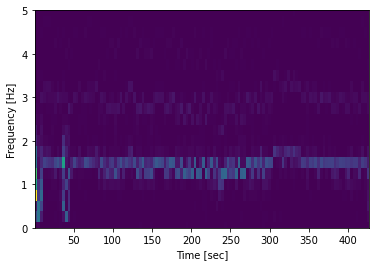

In [17]:
f, t, bvp_mh_spect = signal.spectrogram(bvp_mh['BVP'], fs = 64)
plt.pcolormesh(t, f, bvp_mh_spect, shading = 'nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)  
plt.show()

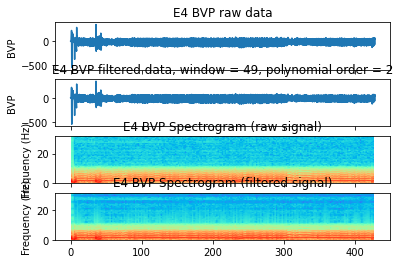

In [18]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
ax1.plot(bvp_mh['Second'], bvp_mh['BVP'])
ax1.set_ylabel('BVP')
ax1.set_xlim(2200, 2300)
ax1.set_title('E4 BVP raw data')

ax2.plot(bvp_mh['Second'], bvp_mh_filtered)
ax2.set_ylabel('BVP')
ax2.set_xlim(2200, 2300)
ax2.set_title('E4 BVP filtered data, window = 49, polynomial order = 2')

ax3.specgram(bvp_mh['BVP'], Fs = 64, cmap = 'rainbow')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('E4 BVP Spectrogram (raw signal)')

ax4.specgram(bvp_mh_filtered, Fs = 64, cmap = 'rainbow')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('E4 BVP Spectrogram (filtered signal)')

plt.rcParams["figure.figsize"] = (20,20)

# Filtering (bandpass + moving average)

In [14]:
# band pass filter (0.5-20 Hz, order = 3) + 3 point moving average
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [15]:
# use two-step denoising on a short period of data
bvp_seg = bvp_yh[145920:261120]
bvp_seg.reset_index()
bvp_seg_filtered = butter_bandpass_filter(bvp_seg['BVP'].to_numpy(), lowcut = 0.5, highcut = 6, fs = 64, order = 3)

bvp_seg_mh = bvp_mh.iloc[3000:10000]
bvp_seg_mh.reset_index()
bvp_seg_filt_mh = butter_bandpass_filter(bvp_seg_mh['BVP'].to_numpy(), lowcut = 0.5, highcut = 6, fs = 64, order = 3)

In [16]:
bvp_seg_mh

,BVP,Second
Timestamp,,
1644606621.88,32.94,46.88
1644606621.89,33.57,46.89
1644606621.91,33.52,46.91
1644606621.92,33.13,46.92
1644606621.94,32.86,46.94
...,...,...
1644606731.17,30.05,156.17
1644606731.19,44.17,156.19
1644606731.20,53.46,156.20


In [17]:
bvp_mh.reset_index()

,Timestamp,BVP,Second
0,1644606575.00,-0.00,0.00
1,1644606575.02,-0.00,0.02
2,1644606575.03,-0.00,0.03
3,1644606575.05,-0.00,0.05
4,1644606575.06,-0.00,0.06
...,...,...,...
27440,1644607003.75,69.71,428.75
27441,1644607003.77,68.59,428.77
27442,1644607003.78,65.54,428.78
27443,1644607003.80,60.87,428.80


In [18]:
bvp_mh.iloc[3000:10000]

,BVP,Second
Timestamp,,
1644606621.88,32.94,46.88
1644606621.89,33.57,46.89
1644606621.91,33.52,46.91
1644606621.92,33.13,46.92
1644606621.94,32.86,46.94
...,...,...
1644606731.17,30.05,156.17
1644606731.19,44.17,156.19
1644606731.20,53.46,156.20


In [23]:
bvp_seg['filtered_BVP'] = bvp_seg_filtered
bvp_seg_mh['filtered_BVP'] = bvp_seg_filt_mh

C:\Users\maoyuan2\AppData\Local\Temp/ipykernel_15256/171290553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvp_seg['filtered_BVP'] = bvp_seg_filtered
C:\Users\maoyuan2\AppData\Local\Temp/ipykernel_15256/171290553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvp_seg_mh['filtered_BVP'] = bvp_seg_filt_mh


In [24]:
bvp_seg['mov_ave_BVP'] = bvp_seg.filtered_BVP.rolling(3, min_periods = 1).mean()
bvp_seg_mh['mov_ave_BVP'] = bvp_seg_mh.filtered_BVP.rolling(3, min_periods = 1).mean()

C:\Users\maoyuan2\AppData\Local\Temp/ipykernel_15256/2637772668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvp_seg['mov_ave_BVP'] = bvp_seg.filtered_BVP.rolling(3, min_periods = 1).mean()
C:\Users\maoyuan2\AppData\Local\Temp/ipykernel_15256/2637772668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvp_seg_mh['mov_ave_BVP'] = bvp_seg_mh.filtered_BVP.rolling(3, min_periods = 1).mean()


In [25]:
bvp_seg_mh.reset_index()

,Timestamp,BVP,Second,filtered_BVP,mov_ave_BVP
0,1644606621.88,32.94,46.88,0.40,0.40
1,1644606621.89,33.57,46.89,2.37,1.39
2,1644606621.91,33.52,46.91,6.73,3.17
3,1644606621.92,33.13,46.92,12.73,7.28
4,1644606621.94,32.86,46.94,18.65,12.70
...,...,...,...,...,...
6995,1644606731.17,30.05,156.17,-1.50,-22.65
6996,1644606731.19,44.17,156.19,23.17,-0.82
6997,1644606731.20,53.46,156.20,47.00,22.89
6998,1644606731.22,58.93,156.22,67.26,45.81


<IPython.core.display.Javascript object>


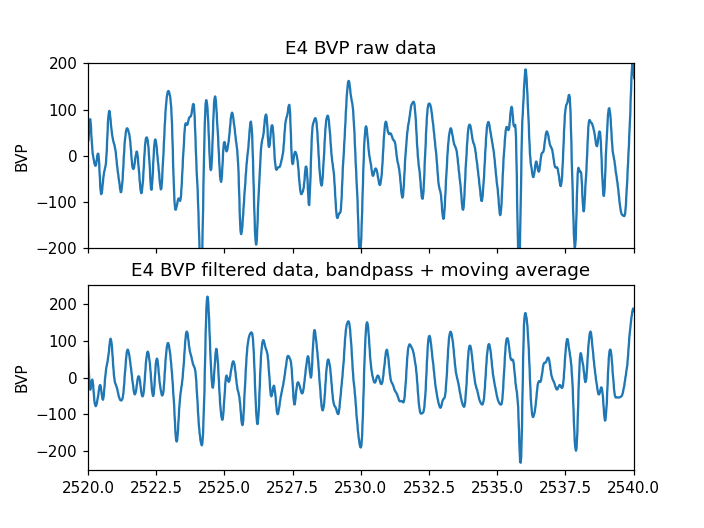

Text(0.5, 1.0, 'E4 BVP filtered data, bandpass + moving average')

In [22]:
# plot raw and filtered segment
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(bvp_seg['Second'], bvp_seg['BVP'])
ax1.set_ylabel('BVP')
ax1.set_xlim(2520, 2540)
ax1.set_ylim(-200, 200)
ax1.set_title('E4 BVP raw data')

ax2.plot(bvp_seg['Second'], bvp_seg['mov_ave_BVP'])
ax2.set_ylabel('BVP')
ax2.set_xlim(2520, 2540)
ax2.set_ylim(-250, 250)
ax2.set_title('E4 BVP filtered data, bandpass + moving average')


## Noise elimination (two-step denoising proposed by Heo)

In [28]:
#denoising function - use all statistics as SQI
def ppg_denoising(filtered_signal, valley):
    denoised = pd.DataFrame(columns = ['Timestamp', 'BVP', 'Second', 'filtered_BVP', 'mov_ave_BVP'])
    stdv_seg = []
    kurt_seg = []
    skew_seg = []
    for i in range(len(valley)-1):
        i_s = valley[i]
        i_f = valley[i+1] # discard the first segment
        segment = filtered_signal.iloc[i_s:i_f]

        # calculate the statistics

        stdv = segment.detrended_BVP.std()
        kurt = stats.kurtosis(segment.detrended_BVP)
        skewness = stats.skew(segment.detrended_BVP)

        # averaging the statistics

        stdv_seg.append(stdv)
        kurt_seg.append(kurt)
        skew_seg.append(skewness)

    stdv_thre = statistics.mean(stdv_seg) + 1.0
    kurt_thre = statistics.mean(kurt_seg) + 2.0
    skew_thre_up = statistics.mean(skew_seg) + 1.5
    skew_thre_lo = statistics.mean(skew_seg) - 1.8

    for i in range(len(valley)-1):    
        # threshold
        i_s = valley[i]
        i_f = valley[i+1]
        segment = filtered_signal[i_s:i_f]
        stdv = segment.detrended_BVP.std()
        kurt = stats.kurtosis(segment.detrended_BVP)
        skewness = stats.skew(segment.detrended_BVP)
        if stdv > stdv_thre or kurt > kurt_thre or skew_thre_up < skewness or skew_thre_lo > skewness:
            denoised = denoised
            print("noise", stdv, kurt, skewness, stdv_thre, kurt_thre, skew_thre_up, skew_thre_lo)
        else: 
            #print("good")
            #egment = segment.reset_index()
            denoised = denoised.append(segment, ignore_index = True)
        
    return denoised

In [37]:
#denoising function - use all statistics as SQI
def ppg_denoising_skew(filtered_signal, valley):
    denoised = pd.DataFrame(columns = ['Timestamp', 'BVP', 'Second', 'filtered_BVP', 'mov_ave_BVP'])
    stdv_seg = []
    kurt_seg = []
    skew_seg = []
    for i in range(len(valley)-1):
        i_s = valley[i]
        i_f = valley[i+1] # discard the first segment
        segment = filtered_signal.iloc[i_s:i_f]

        # calculate the statistics

        stdv = segment.detrended_BVP.std()
        kurt = stats.kurtosis(segment.detrended_BVP)
        skewness = stats.skew(segment.detrended_BVP)

        # averaging the statistics

        stdv_seg.append(stdv)
        kurt_seg.append(kurt)
        skew_seg.append(skewness)

    stdv_thre = statistics.mean(stdv_seg) + 1.0
    kurt_thre = statistics.mean(kurt_seg) + 2.0
    skew_thre_up = statistics.mean(skew_seg) + 1.5
    skew_thre_lo = statistics.mean(skew_seg) - 1.8

    for i in range(len(valley)-1):    
        # threshold
        i_s = valley[i]
        i_f = valley[i+1]
        segment = filtered_signal[i_s:i_f]
        stdv = segment.detrended_BVP.std()
        kurt = stats.kurtosis(segment.detrended_BVP)
        skewness = stats.skew(segment.detrended_BVP)
        if skew_thre_up < skewness or skew_thre_lo > skewness:
            denoised = denoised
            print("noise", stdv, kurt, skewness, stdv_thre, kurt_thre, skew_thre_up, skew_thre_lo)
        else: 
            #print("good")
            #egment = segment.reset_index()
            denoised = denoised.append(segment, ignore_index = True)
        
    return denoised

In [30]:
def findvalley(signal):
    valley = (np.diff(np.sign(np.diff(signal.to_numpy()))) > 0).nonzero()[0] + 1         # local min
    new_valley = []
    for i in range(len(valley)-1):
        i_s = valley[i]
        i_f = valley[i+1]
        if (i_f - i_s) >= 32:
            new_valley.append(valley[i])
            #new_valley.append(b[i+1])
    return new_valley

In [31]:
detrend_seg = signal.detrend(bvp_seg.mov_ave_BVP, type = 'linear')
bvp_seg['detrended_BVP'] = detrend_seg.tolist()

C:\Users\maoyuan2\AppData\Local\Temp/ipykernel_24240/249665627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvp_seg['detrended_BVP'] = detrend_seg.tolist()


In [32]:
bvp_seg

,Timestamp,BVP,Second,filtered_BVP,mov_ave_BVP,detrended_BVP
145920,1644589773.00,-36.21,2280.00,-0.44,-0.44,-0.45
145921,1644589773.02,-39.33,2280.02,-2.64,-1.54,-1.54
145922,1644589773.03,-46.92,2280.03,-7.67,-3.58,-3.59
145923,1644589773.05,-60.08,2280.05,-15.20,-8.50,-8.50
145924,1644589773.06,-77.90,2280.06,-24.18,-15.68,-15.69
...,...,...,...,...,...,...
261115,1644591572.92,4.84,4079.92,27.84,21.78,21.79
261116,1644591572.94,7.94,4079.94,32.74,27.52,27.52
261117,1644591572.95,10.57,4079.95,36.39,32.33,32.33
261118,1644591572.97,12.72,4079.97,38.71,35.95,35.95


In [33]:
valleys = findvalley(bvp_seg['detrended_BVP'])
bvp_denoised = ppg_denoising(bvp_seg, valleys)

noise 115.8560019944207 -1.1055678940158835 -0.3063765044299226 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 126.79453937620873 -0.9863457037543348 0.04322404213154247 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 187.88879322902054 -0.7291430280763027 0.7613684353588889 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 115.43522795708085 -0.4592119290225054 0.20529443991103402 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 131.0843197332401 -0.6203753173646236 -0.1423251085472228 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 105.0685894536983 0.7465341406413954 1.0618666386745086 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 88.77402436347394 0.8279205750651975 -0.19212459865075612 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 109.1721094057

noise 136.43584235233286 -0.9156671650975254 -0.6590331722274603 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 201.87491434728378 -0.2613444677316852 0.9111305746090567 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 187.58553209346715 -0.7115322681106728 -0.9115124363161421 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 594.6378552586139 -1.0630756090310454 0.5776537862917103 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 157.40701490799253 -0.7701768606734092 -0.8515023149214573 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 123.0217298799689 0.7411387450039331 -1.2218792119653032 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 88.73081695718818 -0.43952780639861944 -0.8482643548003185 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 95.464031018

noise 101.46261222911312 -1.214170883619672 -0.1669735253223814 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 80.79140108792592 -1.4148530065216673 -0.06365745867772325 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 113.17910044828723 -1.371945662602774 0.3047835850668799 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 80.70452716280744 -0.9767877575088129 0.32016370933064187 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 83.21326357962171 -1.2750529364067824 0.24342503908838403 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 94.76781157849244 -1.2453084581401506 -0.29615677923113537 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 77.65679836211557 -0.7526122060337146 -0.6696016055600142 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 196.069085853

noise 311.1781251892841 -1.5062800076475336 -0.3768884405728292 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 227.06626735358824 -1.0572860649931575 -0.21085318384166205 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 301.57743363457286 -1.1421691838924442 -0.1067019922730244 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 135.89395758857208 0.8718297404072421 0.32604042847568676 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 197.46684197620655 0.30654631065487514 1.2597544040901172 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 142.47183117051796 -1.2207545563534814 -0.5596882755327796 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 91.64681926997433 -0.36721910928471857 -0.19800484159839926 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 129.7609

noise 109.04888187522782 -0.18842371231949206 -0.8058765657864531 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 97.45443059941312 0.4176262625100824 -0.9515472871522632 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 152.54277432339688 -1.758115763521967 0.17156019693546376 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 288.7757497465302 -1.580464269643998 -0.18654062766257415 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 301.9044398485802 -0.9194877682453964 0.19542093345176545 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 331.31142290677667 -1.2973694673665 -0.2699793025487133 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 259.6446169245017 -1.3162869367048662 -0.4637609406607775 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 112.43754116942

noise 119.09502485179259 -0.883751107137634 -0.19906611553135892 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 82.13308788223623 -0.9201043888428537 0.6178253221381157 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 139.55333959291693 -0.018168638728915276 1.082048591509539 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 118.40794495568456 -1.3069712575063153 -0.10193361595618027 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 175.5428020730087 -0.948682809332186 -0.06707733895836139 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 104.49998689426754 -1.187925847781626 -0.3975251027568387 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 78.6114384978937 0.3792439529660321 -1.2580109738916487 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 91.2014761608

In [68]:
def plot_denoised(denoised_signal, original_signal, valley_denoised, valley_original):

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Before vs After Two-step Denoising')   
    
    ax1.plot(original_signal['Second'], original_signal['mov_ave_BVP'], color='grey')
    ax1.plot(original_signal['Second'].iloc[valley_original], original_signal['mov_ave_BVP'].iloc[valley_original], "o", label="min", color='b')
    #plt.plot(bvp_seg_deno['Second'].iloc[c], bvp_seg_deno['mov_ave_BVP'].iloc[c], "o", label="max", color='b')
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('BVP')
    ax1.set_xlim(2850, 2950)
    ax1.title.set_text('PPG signal after filtering')
    
    ax2.plot(denoised_signal['Second'], denoised_signal['detrended_BVP'], color='grey')
    ax2.plot(denoised_signal['Second'].iloc[valley_denoised], denoised_signal['detrended_BVP'].iloc[valley_denoised], "o", label="min", color='r')
    #plt.plot(bvp_seg_deno['Second'].iloc[c], bvp_seg_deno['detrended_BVP'].iloc[c], "o", label="max", color='b')
    ax2.set_ylabel('BVP')
    ax2.title.set_text('PPG signal after denoising')
    ax2.set_xlim(2850, 2950)
    plt.show()

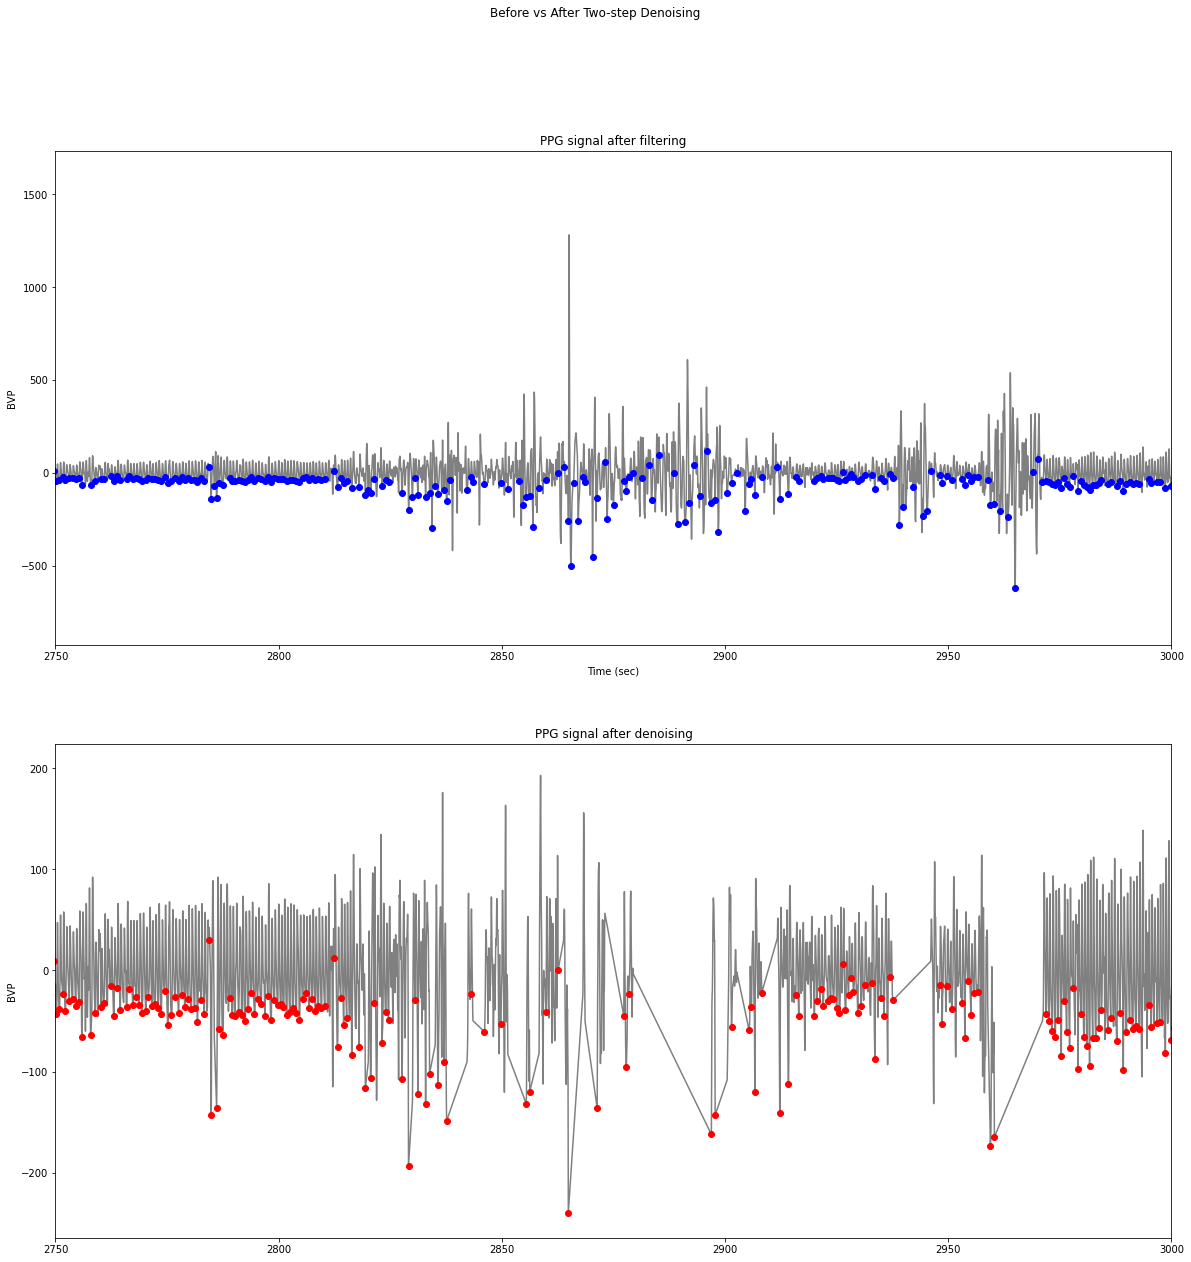

In [65]:
valleys_original = findvalley(bvp_seg['mov_ave_BVP'])
valleys_denoised = findvalley(bvp_denoised['detrended_BVP'])
plot_denoised(bvp_denoised, bvp_seg, valleys_denoised, valleys_original)

In [57]:
valleys = findvalley(bvp_seg['detrended_BVP'])
bvp_denoised_skw = ppg_denoising_skew(bvp_seg, valleys)

noise 45.2909301981906 27.506654650600495 -4.377384921171107 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 86.62175368163018 4.3569377111148855 -1.8214145722974466 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 142.8910437497234 4.270744926999111 1.5611465409258447 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 39.96892399792119 11.074408124583575 -3.0607523170427893 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 46.36768140986449 4.309808941209382 -1.8943200707902939 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 35.7602876728978 3.8202505774494284 -1.9531873592961158 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 74.78440390546126 3.9318234459515224 -1.9768276445852244 77.56585708095184 1.3403942063067968 1.5046439122410535 -1.7953560877589465
noise 45.398511229861036 5.338417

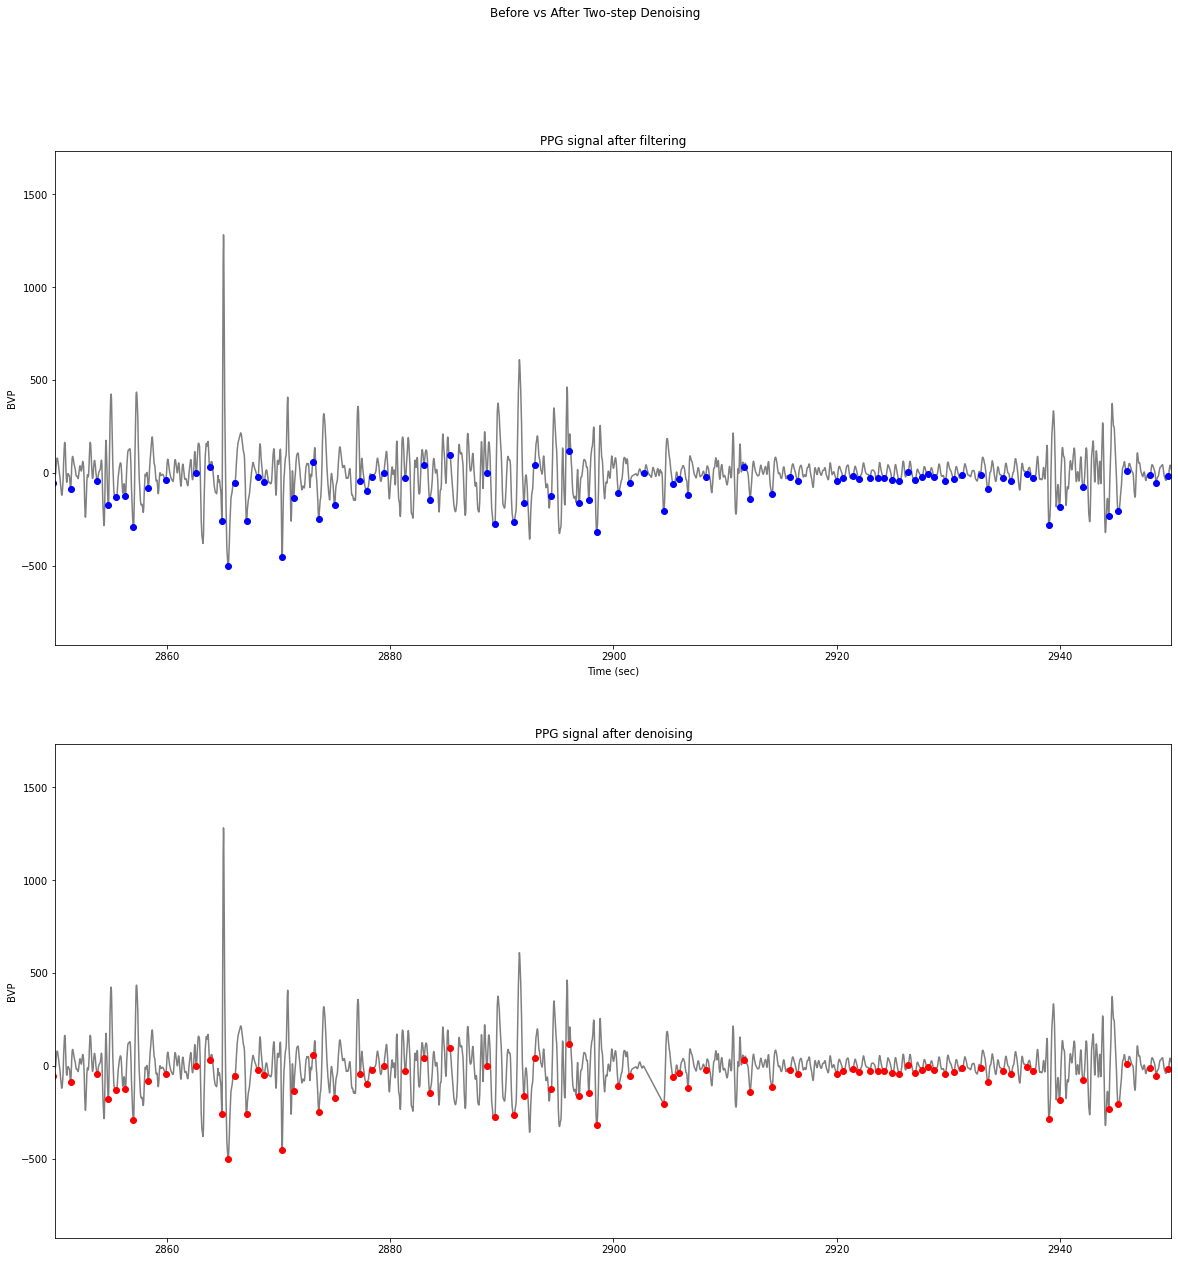

In [69]:
valleys_original = findvalley(bvp_seg['mov_ave_BVP'])
valleys_denoised_skw = findvalley(bvp_denoised_skw['detrended_BVP'])
plot_denoised(bvp_denoised_skw, bvp_seg, valleys_denoised_skw, valleys_original)

# Empirical Mode Decomposition

In [26]:
import emd

In [27]:
imf = emd.sift.sift(bvp_seg_mh['filtered_BVP'].iloc[4000:6000])

C:\Users\maoyuan2\AppData\Local\Programs\Python\Python39\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


In [28]:
sample_rate = 256
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_range = (0.5, 5, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

<IPython.core.display.Javascript object>


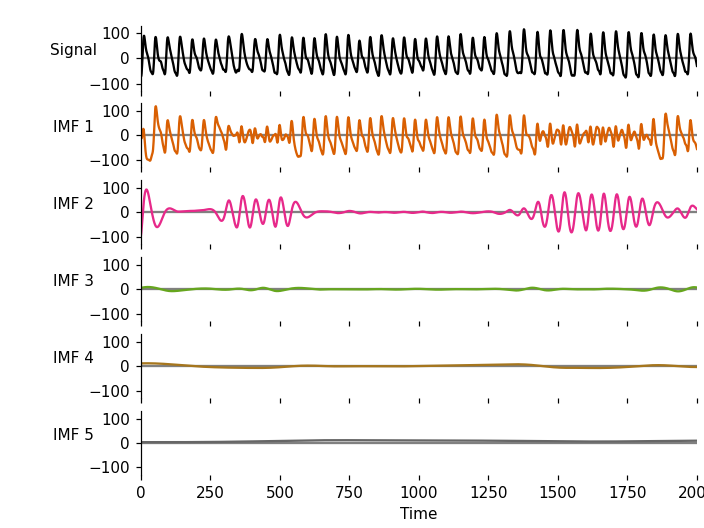

In [29]:
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

In [30]:
bvp_seg_emd = bvp_seg['filtered_BVP'].iloc[18000:20000]
imf = emd.sift.sift(bvp_seg_emd)
sample_rate = 256
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_range = (0.5, 10, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

C:\Users\maoyuan2\AppData\Local\Programs\Python\Python39\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


<IPython.core.display.Javascript object>


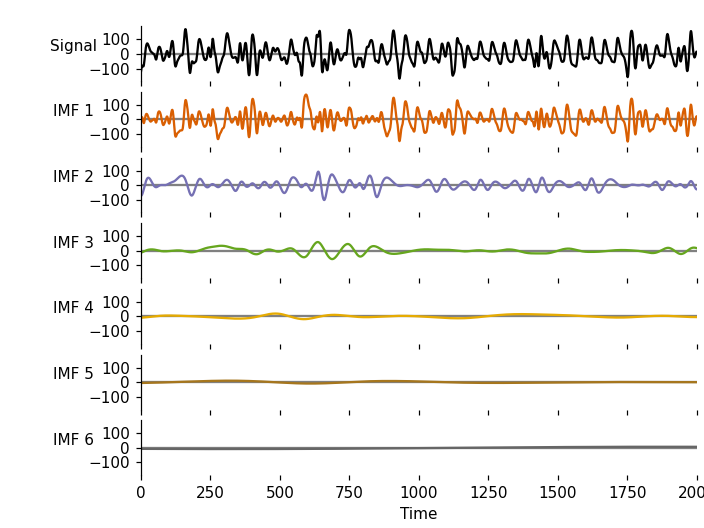

In [31]:
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

# Ensemble EMD

In [35]:
# imf_opts = {'sd_thresh': 0.05}
# imf = np.zeros((bvp_seg_mh['filtered_BVP'].iloc[4000:6000].shape[0], 5))

# # Standard sift
# imf[:, 0] = emd.sift.get_next_imf(bvp_seg_mh['filtered_BVP'].iloc[4000:6000], **imf_opts)[0][:, 0]

# # Additive noise sifts
# noise_variance = 1
# for ii in range(4):
#     imf[:, ii+1] = emd.sift.get_next_imf(bvp_seg_mh['filtered_BVP'].iloc[4000:6000] + np.random.randn(bvp_seg_mh['filtered_BVP'].iloc[4000:6000].shape[0],)*noise_variance, **imf_opts)[0][:, 0]

# plt.figure()
# for ii in range(5):
#     plt.subplot(5, 1, ii+1)
#     plt.plot(imf[:, ii])

#     if ii == 0:
#         plt.ylabel('Normal')
#     else:
#         plt.ylabel('Ens. {0}'.format(ii))

# plt.figure()
# plt.subplot(211)
# plt.plot(imf[:, 0])
# plt.ylabel('Normal')
# plt.subplot(212)
# plt.plot(imf[:, 1:].mean(axis=1))
# plt.ylabel('Ens. Avg')

C:\Users\maoyuan2\AppData\Local\Programs\Python\Python39\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


<IPython.core.display.Javascript object>


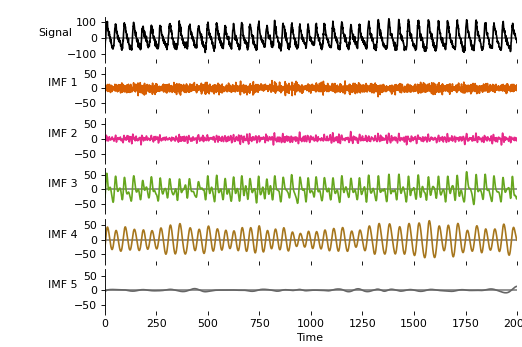

In [87]:
ppg_sig = bvp_seg_mh['filtered_BVP'].iloc[4000:6000]
imf = emd.sift.ensemble_sift(ppg_sig, max_imfs=5, nensembles=24, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)

C:\Users\maoyuan2\AppData\Local\Programs\Python\Python39\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


<IPython.core.display.Javascript object>


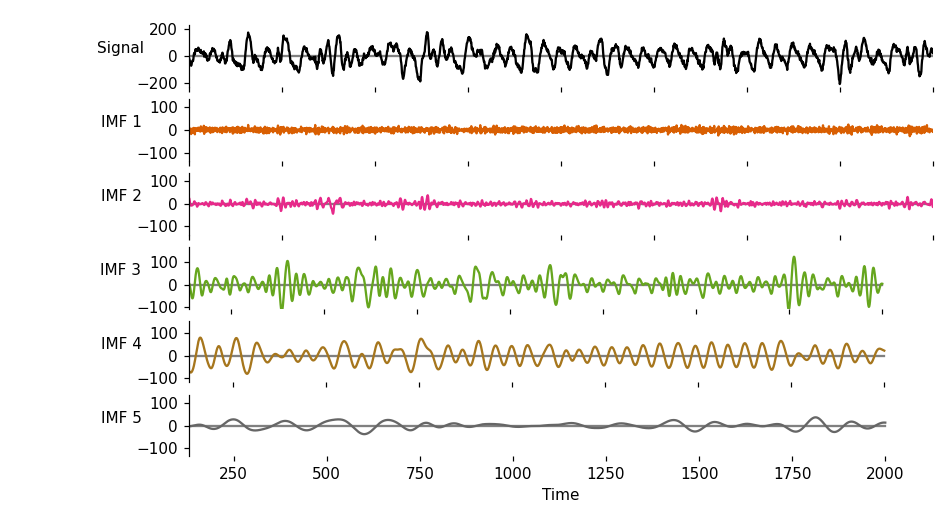

In [55]:
ppg_sig = bvp_seg['BVP'].iloc[18000:20000]
imf = emd.sift.ensemble_sift(ppg_sig, max_imfs=5, nensembles=48, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)

C:\Users\maoyuan2\AppData\Local\Programs\Python\Python39\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


<IPython.core.display.Javascript object>


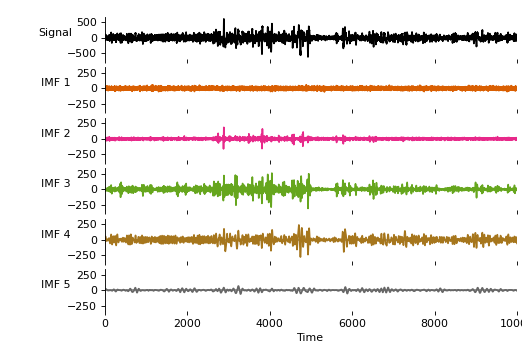

In [100]:
ppg_sig = bvp_seg['filtered_BVP'].iloc[18000:28000]
imf = emd.sift.ensemble_sift(ppg_sig, max_imfs=5, nensembles=24, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)

In [106]:
#plot extracted PPG (IMF `, 2 and 3)
def plot_imf(imf, original_sig):
    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    ax1.plot(imf[:, 3])
    ax1.set_ylabel('BVP')
    ax1.set_title('E4 PPG signal extracted using EMD')

    ax2.plot(original_sig)
    ax2.set_ylabel('BVP')
    ax2.set_title('E4 Filtered PPG signal')

<IPython.core.display.Javascript object>


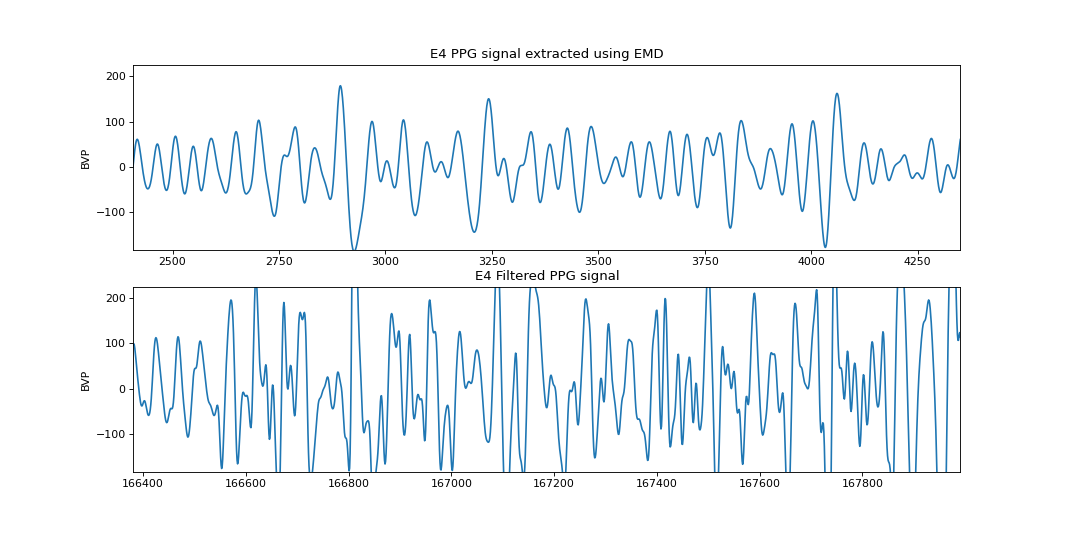

In [107]:
plot_imf(imf, ppg_sig)

In [99]:
# 
# Sliding window min/max (Python)
# 
# Copyright (c) 2020 Project Nayuki. (MIT License)
# https://www.nayuki.io/page/sliding-window-minimum-maximum-algorithm
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
# - The above copyright notice and this permission notice shall be included in
#   all copies or substantial portions of the Software.
# - The Software is provided "as is", without warranty of any kind, express or
#   implied, including but not limited to the warranties of merchantability,
#   fitness for a particular purpose and noninfringement. In no event shall the
#   authors or copyright holders be liable for any claim, damages or other
#   liability, whether in an action of contract, tort or otherwise, arising from,
#   out of or in connection with the Software or the use or other dealings in the
#   Software.
# 

import collections


# ---- Function for one-shot computation ----

def compute(array, window, maximize):
	if not isinstance(window, int):
		raise TypeError()
	if not isinstance(maximize, bool):
		raise TypeError()
	if window <= 0:
		raise ValueError("Window size must be positive")
	
	result = []
	deque = collections.deque()
	for (i, val) in enumerate(array):
		val = array[i]
		while len(deque) > 0 and ((not maximize and val < deque[-1]) or (maximize and val > deque[-1])):
			deque.pop()
		deque.append(val)
		
		j = i + 1 - window
		if j >= 0:
			result.append(deque[0])
			if array[j] == deque[0]:
				deque.popleft()
	return result



# ---- Stateful instance for incremental computation ----

class SlidingWindowMinMax:
	
	def __init__(self):
		self.mindeque = collections.deque()
		self.maxdeque = collections.deque()
	
	
	def get_minimum(self):
		return self.mindeque[0]
	
	
	def get_maximum(self):
		return self.maxdeque[0]
	
	
	def add_tail(self, val):
		while len(self.mindeque) > 0 and val < self.mindeque[-1]:
			self.mindeque.pop()
		self.mindeque.append(val)
		
		while len(self.maxdeque) > 0 and val > self.maxdeque[-1]:
			self.maxdeque.pop()
		self.maxdeque.append(val)
	
	
	def remove_head(self, val):
		if val < self.mindeque[0]:
			raise ValueError("Wrong value")
		elif val == self.mindeque[0]:
			self.mindeque.popleft()
		
		if val > self.maxdeque[0]:
			raise ValueError("Wrong value")
		elif val == self.maxdeque[0]:
			self.maxdeque.popleft()